# Import necessary libraries

2025-10-19 06:08:56.546100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760854136.796147      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760854136.879705      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Loading metadata...

MEMORY-EFFICIENT CONTRAIL DETECTION

Creating model...


I0000 00:00:1760854150.774600      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760854150.775376      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "Compact_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,624 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][

 Total params: 1,954,241 (7.45 MB)

 Trainable params: 1,951,425 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

None

Steps per epoch: 150
Validation steps: 12

Starting training...
Epoch 1/30


I0000 00:00:1760854170.945484      98 service.cc:148] XLA service 0x7f5e340038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760854170.946630      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760854170.946652      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1760854173.093760      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1760854180.212045      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760854180.461057      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:37:01 39s/step - accuracy: 0.4636 - dice_coef: 0.0069 - loss: 0.7143

I0000 00:00:1760854193.410165      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8271 - dice_coef: 0.0362 - loss: 0.6831
Epoch 1: val_dice_coef improved from -inf to 0.04109, saving model to best_model.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.8274 - dice_coef: 0.0363 - loss: 0.6831 - val_accuracy: 0.9479 - val_dice_coef: 0.0411 - val_loss: 0.6756 - learning_rate: 3.0000e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9173 - dice_coef: 0.0742 - loss: 0.6551
Epoch 2: val_dice_coef improved from 0.04109 to 0.07882, saving model to best_model.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.9174 - dice_coef: 0.0743 - loss: 0.6550 - val_accuracy: 0.8868 - val_dice_coef: 0.0788 - val_loss: 0.6538 - learning_rate: 3.0000e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9579 - dice_coef: 0.1247 - loss: 0.6209
Epoch 3: val_dice_coef improved from 0.07882 to 0.16219, saving model to best_model.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.95

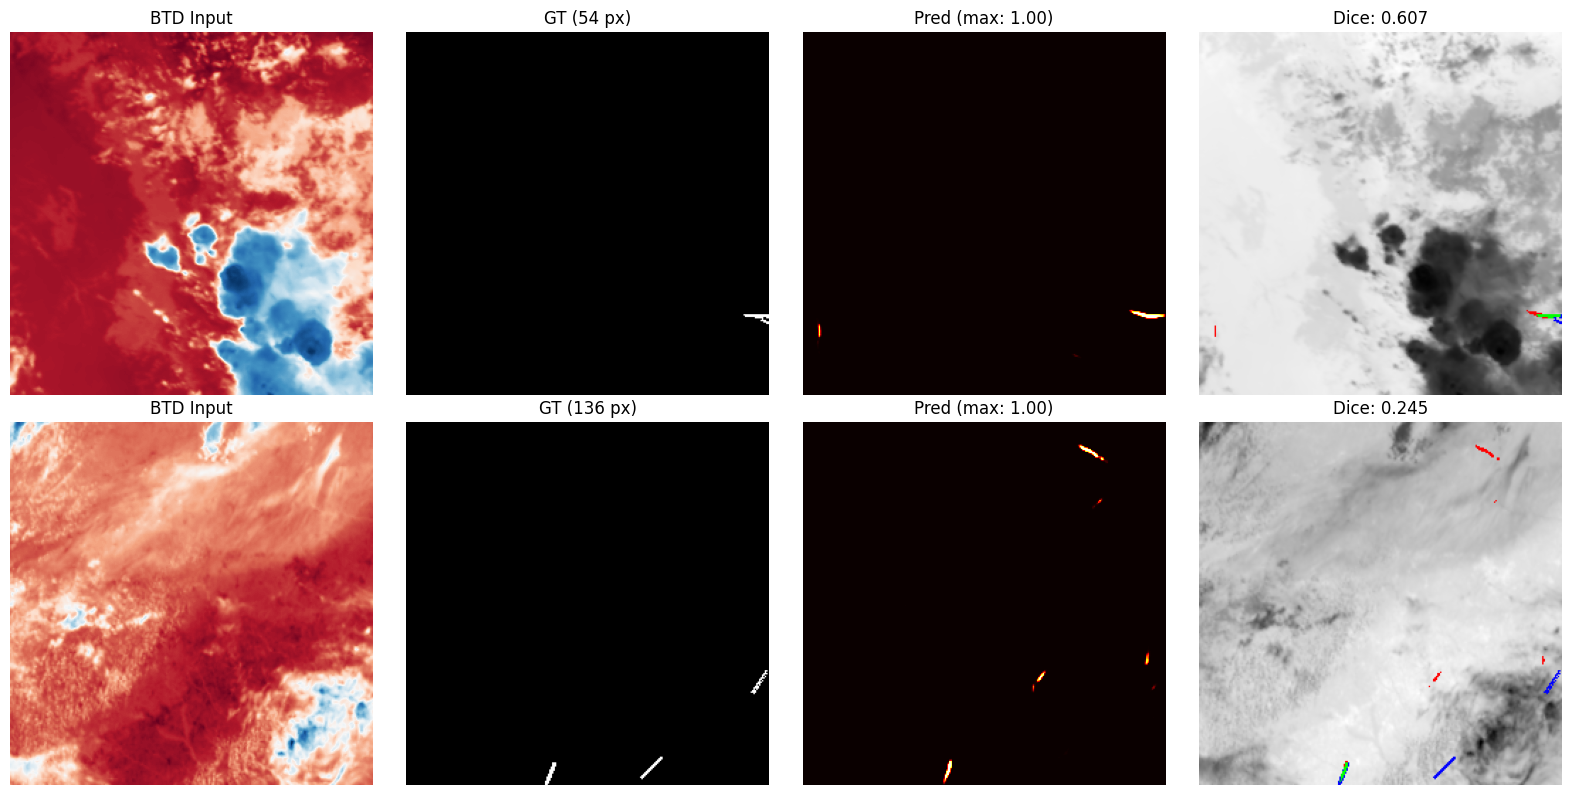

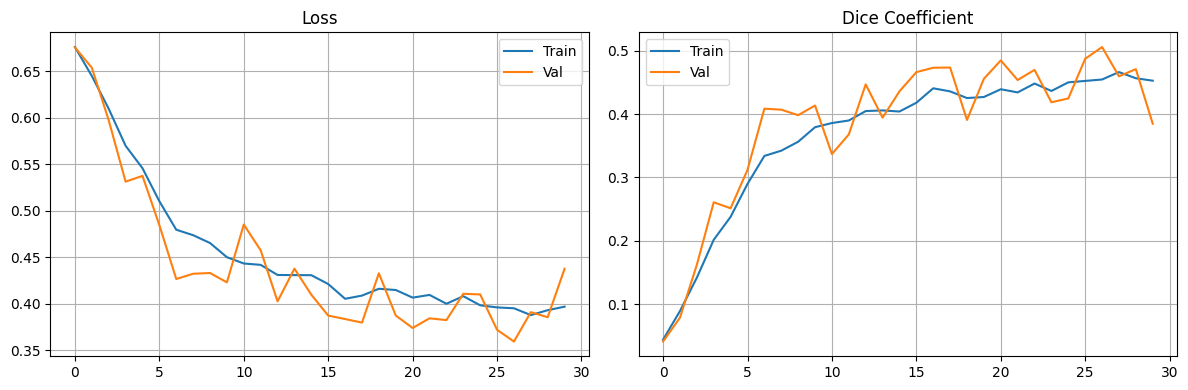


✅ Model saved as 'final_model.keras'

🎉 Training completed!
Memory-efficient settings:
  - Image size: 256x256
  - Batch size: 4
  - Max samples: 600
  - Input channels: 9 (3 timesteps × 3 features)
  - Using data generator (no full dataset in memory)


In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

def create_optimized_optimizer(learning_rate=3e-4):
    """
    Create AdamW optimizer with better defaults inspired by Ranger
    AdamW combines Adam with decoupled weight decay (similar to RAdam benefits)
    """
    return keras.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=0.95,  # Higher momentum (Ranger recommendation)
        beta_2=0.999,
        weight_decay=0.01,  # Decoupled weight decay
        clipnorm=1.0  # Gradient clipping for stability
    )

# Memory-efficient configuration
CONFIG = {
    'img_height': 256,
    'img_width': 256,
    'batch_size': 4,  # Increased for better gradients
    'epochs': 30,
    'learning_rate': 3e-4,  # Higher learning rate
    'random_seed': 42,
    'max_samples': 600,  # More samples
    'min_contrail_pixels': 100,  # Ensure meaningful contrails
}

tf.random.set_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("Loading metadata...")
with open("/kaggle/input/google-research-identify-contrails-reduce-global-warming/train_metadata.json") as f:
    train_meta = json.load(f)

BASE_PATH = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

def normalize_range(data):
    """Better normalization for satellite data"""
    data = data.astype(np.float32)
    # Use mean/std instead of percentile for better stability
    mean = np.mean(data)
    std = np.std(data)
    if std > 0:
        return (data - mean) / (std + 1e-8)
    return data - mean

def load_sample_memory_efficient(record_id):
    """Load with minimal memory footprint"""
    record_path = os.path.join(TRAIN_PATH, record_id)
    
    try:
        # Load only essential bands
        band15 = np.load(os.path.join(record_path, "band_15.npy"))
        band14 = np.load(os.path.join(record_path, "band_14.npy"))
        band11 = np.load(os.path.join(record_path, "band_11.npy"))
        mask = np.load(os.path.join(record_path, "human_pixel_masks.npy"))
        
        # Use middle timestep and neighbors
        n_times = band15.shape[2]
        mid = n_times // 2
        
        # Get 3 timesteps around middle
        if n_times >= 3:
            times = [max(0, mid-1), mid, min(n_times-1, mid+1)]
        else:
            times = [mid] * 3
        
        channels = []
        for t in times:
            b15 = normalize_range(band15[:, :, t])
            b14 = normalize_range(band14[:, :, t])
            b11 = normalize_range(band11[:, :, t])
            btd = b15 - b14  # Most important feature!
            
            channels.extend([btd, b15, b11])  # BTD first!
        
        image = np.stack(channels[:9], axis=-1).astype(np.float32)
        
        # Process mask - take maximum across all annotations
        if len(mask.shape) == 3:
            mask = np.max(mask, axis=-1)
        mask = mask.astype(np.float32)
        
        # Resize with better interpolation
        image = tf.image.resize(image, [CONFIG['img_height'], CONFIG['img_width']], 
                               method='bilinear').numpy()
        mask = tf.image.resize(np.expand_dims(mask, -1), 
                              [CONFIG['img_height'], CONFIG['img_width']],
                              method='nearest').numpy()  # Use nearest for masks!
        mask = (mask > 0.5).astype(np.float32)
        
        # Clean up
        del band15, band14, band11
        
        return image, mask
        
    except Exception as e:
        return None, None

# Generator for memory efficiency
def data_generator(metadata, batch_size, max_samples, augment=False):
    """Memory-efficient data generator"""
    
    while True:
        batch_images = []
        batch_masks = []
        samples_in_epoch = 0
        
        # Shuffle metadata each epoch
        indices = list(range(len(metadata)))
        np.random.shuffle(indices)
        
        for idx in indices:
            if samples_in_epoch >= max_samples:
                break
                
            meta = metadata[idx]
            image, mask = load_sample_memory_efficient(meta['record_id'])
            
            # Only use samples with significant contrails
            if image is not None and np.sum(mask) > CONFIG['min_contrail_pixels']:
                if augment and np.random.rand() > 0.5:
                    # Random rotation
                    k = np.random.randint(0, 4)
                    image = np.rot90(image, k)
                    mask = np.rot90(mask, k)
                    
                    # Random flip
                    if np.random.rand() > 0.5:
                        image = np.fliplr(image)
                        mask = np.fliplr(mask)
                
                batch_images.append(image)
                batch_masks.append(mask)
                samples_in_epoch += 1
                
                if len(batch_images) == batch_size:
                    yield (np.array(batch_images, dtype=np.float32), 
                           np.array(batch_masks, dtype=np.float32))
                    batch_images = []
                    batch_masks = []
                    gc.collect()
        
        # Yield remaining samples if any
        if len(batch_images) > 0:
            yield (np.array(batch_images, dtype=np.float32), 
                   np.array(batch_masks, dtype=np.float32))
            gc.collect()

# Loss functions
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(tf.squeeze(y_true), tf.float32)
    y_pred = tf.cast(tf.squeeze(y_pred), tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    """Loss optimized for highly imbalanced data"""
    y_true = tf.squeeze(y_true)
    y_pred = tf.squeeze(y_pred)
    
    # Dice loss (main component)
    dice = dice_loss(y_true, y_pred)
    
    # Focal loss (better than BCE for imbalance)
    epsilon = 1e-7
    y_pred_clipped = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    
    # Focal loss with gamma=2
    alpha = 0.75  # Weight for positive class
    gamma = 2.0
    
    p_t = tf.where(y_true > 0.5, y_pred_clipped, 1 - y_pred_clipped)
    alpha_t = tf.where(y_true > 0.5, alpha, 1 - alpha)
    focal = -alpha_t * tf.pow(1 - p_t, gamma) * tf.math.log(p_t)
    focal = tf.reduce_mean(focal)
    
    # Weighted combination
    return 0.7 * dice + 0.3 * focal

# Compact U-Net
def create_compact_unet(input_shape=(256, 256, 9)):
    """Memory-efficient U-Net with dropout"""
    
    def conv_block(x, filters, dropout_rate=0.2):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x
    
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = conv_block(inputs, 32, 0.1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = conv_block(p1, 64, 0.1)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = conv_block(p2, 128, 0.2)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    c4 = conv_block(p3, 256, 0.3)
    
    # Decoder
    u5 = layers.UpSampling2D(2)(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = conv_block(u5, 128, 0.2)
    
    u6 = layers.UpSampling2D(2)(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = conv_block(u6, 64, 0.1)
    
    u7 = layers.UpSampling2D(2)(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = conv_block(u7, 32, 0.1)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
    
    return keras.Model(inputs, outputs, name='Compact_UNet')

print("\n" + "="*60)
print("MEMORY-EFFICIENT CONTRAIL DETECTION")
print("="*60)

# Create model
print("\nCreating model...")
model = create_compact_unet(input_shape=(CONFIG['img_height'], CONFIG['img_width'], 9))

# Use optimized AdamW instead of regular Adam
optimizer = create_optimized_optimizer(learning_rate=CONFIG['learning_rate'])

model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[dice_coef, 'accuracy']
)

print(model.summary())

# Calculate steps
steps_per_epoch = CONFIG['max_samples'] // CONFIG['batch_size']
validation_steps = 50 // CONFIG['batch_size']

print(f"\nSteps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# Split metadata
split_idx = int(len(train_meta) * 0.85)
train_metadata = train_meta[:split_idx]
val_metadata = train_meta[split_idx:]

# Create generators
train_gen = data_generator(train_metadata, CONFIG['batch_size'], CONFIG['max_samples'], augment=True)
val_gen = data_generator(val_metadata, CONFIG['batch_size'], 50, augment=False)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_dice_coef',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

# Train
print("\nStarting training...")
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    verbose=1
)

# Load best model
model.load_weights('best_model.h5')

print("\n=== TRAINING COMPLETED ===")
print(f"Best validation Dice: {max(history.history['val_dice_coef']):.4f}")

# Visualize predictions
print("\nGenerating predictions...")
val_samples = []
val_masks_gt = []

for meta in val_metadata[:6]:
    img, msk = load_sample_memory_efficient(meta['record_id'])
    if img is not None and np.sum(msk) > 50:
        val_samples.append(img)
        val_masks_gt.append(msk)
    if len(val_samples) >= 6:
        break

if len(val_samples) > 0:
    val_samples = np.array(val_samples)
    val_masks_gt = np.array(val_masks_gt)
    predictions = model.predict(val_samples, verbose=0)
    
    fig, axes = plt.subplots(len(val_samples), 4, figsize=(16, 4*len(val_samples)))
    if len(val_samples) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(len(val_samples)):
        # BTD channel
        axes[i, 0].imshow(val_samples[i, :, :, 2], cmap='RdBu_r')
        axes[i, 0].set_title('BTD Input')
        axes[i, 0].axis('off')
        
        # Ground truth
        gt = val_masks_gt[i].squeeze()
        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title(f'GT ({np.sum(gt):.0f} px)')
        axes[i, 1].axis('off')
        
        # Prediction
        pred = predictions[i].squeeze()
        axes[i, 2].imshow(pred, cmap='hot', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Pred (max: {pred.max():.2f})')
        axes[i, 2].axis('off')
        
        # Overlay
        pred_bin = pred > 0.5
        dice = 2 * np.sum(pred_bin * gt) / (np.sum(pred_bin) + np.sum(gt) + 1e-8)
        
        overlay = np.stack([val_samples[i, :, :, 2]]*3, axis=-1)
        overlay = (overlay - overlay.min()) / (overlay.max() - overlay.min() + 1e-8)
        
        tp = np.logical_and(pred_bin, gt > 0)
        fp = np.logical_and(pred_bin, gt == 0)
        fn = np.logical_and(~pred_bin, gt > 0)
        
        overlay[tp] = [0, 1, 0]
        overlay[fp] = [1, 0, 0]
        overlay[fn] = [0, 0, 1]
        
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title(f'Dice: {dice:.3f}')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=100, bbox_inches='tight')
    plt.show()

# Plot history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Val')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['dice_coef'], label='Train')
axes[1].plot(history.history['val_dice_coef'], label='Val')
axes[1].set_title('Dice Coefficient')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=100)
plt.show()

model.save('final_model.keras')
print("\n✅ Model saved as 'final_model.keras'")

# Cleanup
gc.collect()
keras.backend.clear_session()

print("\n🎉 Training completed!")
print(f"Memory-efficient settings:")
print(f"  - Image size: {CONFIG['img_height']}x{CONFIG['img_width']}")
print(f"  - Batch size: {CONFIG['batch_size']}")
print(f"  - Max samples: {CONFIG['max_samples']}")
print(f"  - Input channels: 9 (3 timesteps × 3 features)")
print(f"  - Using data generator (no full dataset in memory)")